<a href="https://colab.research.google.com/github/ekaterinatao/hackathon_books_text_classification/blob/main/code_cru_roberta_ru_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Результаты
Отчет об обучении модели на [wandb](https://api.wandb.ai/links/taoea/w3n73l4o).  
Сохраненный чекпойнт модели на [huggingface](https://huggingface.co/ekaterinatao/books_text_class_roBERTa_ru_base).

### Установка зависимостей

In [1]:
!pip install datasets evaluate seqeval -qqq
!pip install accelerate -U -qqq
!pip install wandb -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import EvalPrediction
from transformers import TrainingArguments, Trainer
import evaluate

import warnings
warnings.filterwarnings("ignore")

### Скачивание датасета

In [3]:
# ссылка на датасет
url = 'https://raw.githubusercontent.com/ekaterinatao/hackathon_books_text_classification/main/data/book_fb2_dataset.csv'

data_raw = pd.read_csv(
    url, sep=',', header=0, names=['text', 'tag']
)
data_raw.head(5)

,text,tag
0,"1.0 — распознавание, вычитка, верстка — sklart...",p
1,Авторы книги считают своим долгом выразить глу...,p
2,Авторы и издатели благодарны руководителям орг...,p
3,В плеяде выдающихся организаторов производства...,p
4,"Он прожил свою жизнь в XX веке, но и в XXI век...",p


In [ ]:
data_raw.shape

(53109, 2)

In [ ]:
data_raw['tag'].nunique()

11

In [4]:
le = LabelEncoder()
data_raw['labels'] = le.fit_transform(data_raw['tag'])

### Подготовка данных к загрузке в DataLoader

In [ ]:
# проверка количества тэгов
data_raw['tag'].value_counts()

p             46266
title          3580
subtitle       1286
poem            895
cite            490
epigraph        273
author          139
annotation       96
book-title       64
publisher        15
keywords          5
Name: tag, dtype: int64

In [ ]:
# т.к. классы несбалансированы, стратифицируем разделение на трэйн и тест
train_text, val_text = train_test_split(
    data_raw, test_size=0.3, stratify=data_raw['tag'], random_state=42
)
print(f'train: {len(train_text)}, val: {len(val_text)}')

train: 37176, val: 15933


In [ ]:
train_text['tag'].value_counts(normalize=True) * 100

p             87.115343
title          6.740908
subtitle       2.420917
poem           1.683882
cite           0.922638
epigraph       0.513772
author         0.260921
annotation     0.180224
book-title     0.121046
publisher      0.029589
keywords       0.010760
Name: tag, dtype: float64

In [ ]:
val_text['tag'].value_counts(normalize=True) * 100

p             87.114793
title          6.740727
subtitle       2.422645
poem           1.688320
cite           0.922613
epigraph       0.514655
author         0.263604
annotation     0.182012
book-title     0.119249
publisher      0.025105
keywords       0.006276
Name: tag, dtype: float64

In [ ]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_text),
    'valid': Dataset.from_pandas(val_text)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__'],
        num_rows: 37176
    })
    valid: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__'],
        num_rows: 15933
    })
})

___
### Токенизация с помощью модели [RoBERTa](https://huggingface.co/DeepPavlov/xlm-roberta-large-en-ru-mnli)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def preprocess_data(examples):
    encoding = tokenizer(examples['text'], truncation=True, max_length=512)
    return encoding

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/xlm-roberta-large-en-ru-mnli")

tokenizer_config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/944k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

encoded_dataset = dataset.map(preprocess_data, batched=True)
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/37176 [00:00<?, ? examples/s]

Map:   0%|          | 0/15933 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 37176
    })
    valid: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 15933
    })
})

In [ ]:
# визуализируем закодированный датасет
df = encoded_dataset['train']
pd.DataFrame({
    'id': df['__index_level_0__'],
    'text': df['text'],
    'tag': df['tag'],
    'labels': df['labels'],
    'input_ids': df['input_ids'],
    'attention_mask': df['attention_mask']
}).sample(5)

,id,text,tag,labels,input_ids,attention_mask
24441,38121,"Как выяснилось из последующего разговора, из о...",p,6,"[tensor(0), tensor(2812), tensor(32798), tenso...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
36458,12233,— Спроси у заурда.,p,6,"[tensor(0), tensor(292), tensor(589), tensor(1...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
14343,33891,"— Плохо, очень плохо, что это у нас не получил...",p,6,"[tensor(0), tensor(292), tensor(20348), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
29181,9132,"— Всё, что я только что рассказала, — просто и...",p,6,"[tensor(0), tensor(292), tensor(26622), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
20904,28356,– А если не поверит? – Шарп побарабанил пальца...,p,6,"[tensor(0), tensor(46), tensor(536), tensor(18...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


### Обучение модели

In [ ]:
# функция для расчета метрик
ACCURACY = evaluate.load("accuracy")
F1 = evaluate.load("f1")
MCC = evaluate.load("matthews_correlation")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions
    preds = np.argmax(preds, axis=1)

    acc_result = ACCURACY.compute(predictions=preds, references=p.label_ids)
    f1_result = F1.compute(predictions=preds, references=p.label_ids, average='weighted')
    mcc_result = MCC.compute(predictions=preds, references=p.label_ids)
    result = {
        "accuracy": acc_result["accuracy"],
        "f1-score": f1_result["f1"],
        "mcc": mcc_result["matthews_correlation"]
    }

    return result

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
os.environ["WANDB_PROJECT"]="books_text_class_roBERTa_ru_base"

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/xlm-roberta-large-en-ru-mnli", num_labels=11, ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/xlm-roberta-large-en-ru-mnli and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([11, 1024]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([11]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
repo_id = "ekaterinatao/books_text_class_roBERTa_ru_base"

training_args = TrainingArguments(
    output_dir=repo_id,
    learning_rate=1e-05,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    num_train_epochs=10,
    #weight_decay=0.0001,
    evaluation_strategy="epoch",
    push_to_hub=True,
    report_to="wandb",
    run_name="batch_5_run",
    save_strategy="no",
    group_by_length=True,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: Currently logged in as: taoea. Use `wandb login --relogin` to force relogin


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Mcc
1,0.161400,0.157530,0.972761,0.968058,0.880637
2,0.121200,0.123655,0.979728,0.979051,0.915861
3,0.129500,0.098705,0.986318,0.985154,0.941085
4,0.060600,0.154978,0.982426,0.980382,0.923362


KeyboardInterrupt: ignored

In [ ]:
wandb.finish()

eval/accuracy,▁▅█▆
eval/f1-score,▁▆█▆
eval/loss,█▄▁█
eval/mcc,▁▅█▆
eval/runtime,▁▂▁█
eval/samples_per_second,█▇█▁
eval/steps_per_second,█▇▇▁
train/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train/learning_rate,▁▂▃▃▄▅▆▆▇████████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆
train/loss,█▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
trainer.save_model(repo_id)

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

### Оценка качества на валидационной выборке

In [ ]:
# подгрузка сохраненного чекпойнта
model = AutoModelForSequenceClassification.from_pretrained(
    repo_id, num_labels=11, ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

In [ ]:
predictions = trainer.predict(test_dataset=encoded_dataset["valid"])

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
predictions.metrics

{'test_loss': 0.09122835099697113,
 'test_accuracy': 0.9873846733195255,
 'test_f1-score': 0.9865976844522558,
 'test_mcc': 0.9465802305226013,
 'test_runtime': 173.4046,
 'test_samples_per_second': 91.883,
 'test_steps_per_second': 18.379}

In [ ]:
preds = predictions.predictions
preds

array([[-1.0109196 , -2.7214274 , -2.2137768 , ..., -2.8687074 ,
        -0.3610453 , -1.9225235 ],
       [-0.93993694, -2.755525  , -2.1792836 , ..., -2.8679984 ,
        -0.26611188, -2.036823  ],
       [-1.0319065 , -2.7118173 , -2.2231102 , ..., -2.86887   ,
        -0.39136872, -1.8827455 ],
       ...,
       [ 0.42654908, -3.825061  , -1.7760122 , ..., -3.2391903 ,
         1.6230253 , -2.280662  ],
       [-2.0019264 , -0.0148155 , -1.0273677 , ..., -1.1822872 ,
        -1.7111206 , 11.365354  ],
       [-0.34705597, -3.1977973 , -2.0095165 , ..., -2.9777913 ,
         0.4579105 , -2.4000797 ]], dtype=float32)

In [ ]:
predicted_labels = np.argmax(preds, axis=1)
print(predicted_labels.shape)
predicted_labels

(15933,)


array([ 6,  6,  6, ...,  6, 10,  6])

In [ ]:
true_labels = encoded_dataset['valid']['labels']
print(true_labels.shape)
true_labels

torch.Size([15933])


tensor([ 6,  6,  6,  ...,  6, 10,  6])

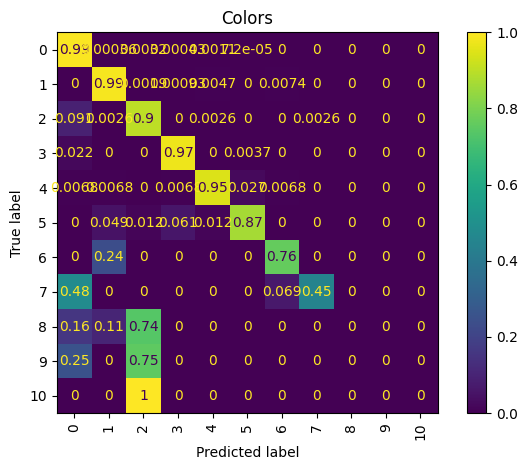

In [ ]:
cn_matrix = confusion_matrix(
    y_true = le.inverse_transform(true_labels.tolist()),
    y_pred = le.inverse_transform(predicted_labels.tolist()),
    labels = le.inverse_transform(data_raw['labels'].value_counts().index).tolist(),
    normalize="true",
)
ConfusionMatrixDisplay(cn_matrix).plot(
    include_values=True, xticks_rotation="vertical"
)
plt.title("Colors")
plt.tight_layout()
plt.show()

In [18]:
ind_to_label = {int(i):label for i, label in zip(data_raw['labels'], data_raw['tag'])}
labels_dict = sorted(list(ind_to_label.items()), key=lambda x: x[0])
labels_dict

[(0, 'annotation'),
 (1, 'author'),
 (2, 'book-title'),
 (3, 'cite'),
 (4, 'epigraph'),
 (5, 'keywords'),
 (6, 'p'),
 (7, 'poem'),
 (8, 'publisher'),
 (9, 'subtitle'),
 (10, 'title')]